# Final Project: Facial Detection #
#### Group member: Hanxiao Yan N16242797, Zijun Huang N11300608, Huai Lin N12507166####

### Please check out our youtube link video. We implemented mult-facial detection code on video!
youtube link https://youtu.be/fg7IklHVJYc
(Hanxiao Yan--Left, Huai Lin--Middle, Zijun Huang--Right)

In [3]:
import keras

Using TensorFlow backend.


In [4]:
import tensorflow as tf
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Introduction:
Background: In recent years, face recognition problem has been more and more popular and attractive to nearly every single person in modern society. Face recognition system is a computer application capable of identifying or verifying a person from a digital image or a video frame from a video source. One of the ways to do this is by comparing selected facial features from the image and a face database. Since we have completed this amazing introduction to machine learning course, we would like to challenge ourselves to accomplish facial detection problem in this project.

Object of this project: Accomplish facial detection implementation by using machine learning knowledges, especially convolutional neural network.

Our idea: 
At first, we want to create a fully connected CNN(no FC layer at all), and then train this network on small images and set up CNN to output a 1x1x1 output. Then run the CNN on larger image, it will output the score for each box in the input image. However, we don't know how to create multi-dimensional labels (y), thus we used FC layers after CNN layers as instead. In this way, we can generate 1-D label very easy. So, following this idea, we begin to build our model as the following steps:

- step1: Transfer learning from well-known model (VGG-16), this could save our time to train model from scrach.
- step2: Add our own layers (FC layers) to VGG-16 and obtain our model.
- step3: Download human pictures and generate face images as part of training samples.
- step4: Training model

After model being built, we try to do:
- step1: Single face detection
- step2: Multi face detection

From the obtained results of singel/multi face dectection, we found our model is not accurate and efficient enough, thus we studied additional knowlege from Coursera deep learning course, and this course introduce YOLO model to us.

# Data details:
In our project, we use:
- The input of training data is a batch of images of shape (m, 64, 64, 3), m samples and each is 64(Height)x64(Width)x3(RGB). Label y=1, non-face. Label y=0, face.
- The output of model is a score(decimal number) which represent the probabilty that whether the corresponding input is a face or an non-face. 
- The input of testing data is one image of shape (512, 512, 3)

## About reference:
Section Ⅰ (Build model), Ⅱ (Single Facial Detection), ⅡⅠ (Multi-Face Detection) are all finished by ourselves, without reference. Section Ⅳ is referenced from Coursera Deep Learning course, we made minor adjustment, we have already notice the code we wrote with comment.

## Ⅰ - Build model

### 1-Transfer learning
Limited to our computation power, we need to use pre-trained model, and we select well-known model VGG-16.

In [27]:
# Clear session at first
keras.backend.clear_session()
# Load the VGG16 network
input_shape = (64, 64, 3)
base_model = applications.VGG16(weights='imagenet', 
                                include_top=False, input_shape=input_shape)

In [28]:
# Create a new model, but freeze the weights in VGG-16
model = Sequential()
# Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False

### 2 - Add additional layers to VGG-16

In [29]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### 3 - Load training data

Use flicker API and Google downloading human images, then generate face images. In training images, there are 215 face class images and 265 non-face images. We then upload our own pictures to test our facial recognition.

In [30]:
train_data_dir = './train'
batch_size = 50
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(64,64),
                        batch_size=batch_size,
                        class_mode='binary')

Found 483 images belonging to 2 classes.


In [31]:
test_data_dir = './test'
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(512,512),
                        batch_size=batch_size,
                        class_mode='binary')

Found 1 images belonging to 1 classes.


### Extract testing data

In [32]:
Xtest = test_generator.next()[0]

### 3.1 -Display Image

In [33]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

### 3.2 - Check training images

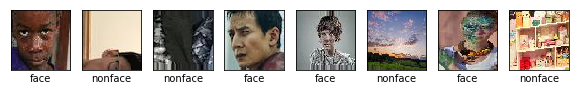

In [34]:
X = train_generator.next()
plt.figure(figsize=(10,10))
nplot = 8
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(X[0][i,:,:,:])
    if X[1][i].astype(int)==1:
        plt.xlabel('nonface')
    elif X[1][i].astype(int)==0:
        plt.xlabel('face')

### 4 - Train model

### 4.1 - Select optimizer and compile model

In [35]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 4.2 - Use training data train our model

In [36]:
model.fit(x=X[0], y=X[1])

Epoch 1/10
50/50 [==============================] - 6s - loss: 0.6325 - acc: 0.6400     
Epoch 2/10
50/50 [==============================] - 5s - loss: 0.3573 - acc: 0.8600     
Epoch 3/10
50/50 [==============================] - 6s - loss: 0.2065 - acc: 0.9200     
Epoch 4/10
50/50 [==============================] - 6s - loss: 0.1610 - acc: 0.9400     
Epoch 5/10
50/50 [==============================] - 6s - loss: 0.1045 - acc: 0.9600     
Epoch 6/10
50/50 [==============================] - 5s - loss: 0.0686 - acc: 0.9800     
Epoch 7/10
50/50 [==============================] - 6s - loss: 0.0322 - acc: 0.9800     
Epoch 8/10
50/50 [==============================] - 6s - loss: 0.0215 - acc: 1.0000     
Epoch 9/10
50/50 [==============================] - 6s - loss: 0.0176 - acc: 1.0000     
Epoch 10/10
50/50 [==============================] - 6s - loss: 0.0092 - acc: 1.0000     


## Ⅱ - Single Facial Detection
Since we has already trained our model with face image, which has size 64x64x3, and also we appended FC layers instead of CNN layers, we can't put the test image (which has size 512x512x3) derectly into our model and do convolution(if we didn't use FC layers as the last layer in our model but CNN layer, we can just directly put the test image, no matter what size it is, and obtain output scoce very fast through convolution). Now that we have to crop the test image (512x512x3) into many parts, each part has size 64x64x3. When cropped image, we use stride=4.Then put each part of test image into model and get scores. Finally, we select the part of test image we cropped (which we can also call "bounding box", because we are going to use this box to highlight face area) of the lowest probability (since we label face as 0), and draw this box on original test image.
- Step1: get the score of each bounding box
- Step2: draw the bounding box with best probability being a face on original test image
- Step3: draw heatmap

### 1 - Get the score of each bounding box. 

### Note: 
Instruction and graph at this part are referenced from Coursera Deep Learning course

We use a simple example to demonstrate our idea:
1. To select a 2x2 part of original test image at the upper left corner of a matrix "test_img" (shape (5,5,3)), we would do:
```python
pic = test_img[0:2,0:2,:]
```
This will be useful when we define `test_img` below, using the `start/end` indexes we define.
2. To find a particular part of the test image we need first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`.
<img src="figure/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='black'>   </center></caption>

In [37]:
def get_box(test_img, output_size, stride):
    import time
    
    probs = [] # Record score for each part of test image
    coordinates = [] # Record location for each part of test image

    start = time.time()
    for row in range(output_size):
        for col in range(output_size):
            
            horiz_star = col*stride
            horiz_end = col*stride+64
            vert_star = row*stride
            vert_end = row*stride+64
            
            pic = test_img[:, vert_star:vert_end, horiz_star:horiz_end, :]
            probability = model.predict(pic)
            coordinates.append([row*4, col*4])
            probs.append(probability)
        if row%10==0:
            # since it's going to take a long time, we print out the process.
            print('In process-------:{0:d}/{1:d}'.format(row, output_size))
    end = time.time()
    running_time = end-start
    
    return probs, coordinates, running_time

In [38]:
# Save the output probabilities with corresponding coordinates.
def save_data(img_name, probs, coordinates):
    with open("{0:s}_probs.p".format(img_name), "wb") as fp:
        pickle.dump(probs, fp)
    with open("{0:s}_coordinate.p".format(img_name), "wb") as fp1:
        pickle.dump(coordinates, fp1)

### 2 - Draw bounding box

In [39]:
def draw_box(probs, coord, img):
    # Get the index of the box which has the highest probability to be a face
    # Since 0 represent face class, thus we use min() to get index
    imin = probs.index(min(probs))
    row, col = coord[imin]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img[:,:,:])
    rect = mpatches.Rectangle((col, row), 64, 64, fill=False, 
                              edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    plt.show()

### 3 - Draw heatmap ##

In [40]:
def draw_heatmap(probs, output_size):
    arr = np.asarray(probs)[:,0,0]
    Arr = np.reshape(arr, (output_size,output_size))
    plt.imshow(Arr,interpolation='none')
    plt.colorbar()

### 4 - Wrap up all our previous methods and try single face recognition

In [45]:
def single_face_detection(img, img_name, img_size, stride, Do_facial=False):
    if Do_facial==True:
        output_size = int((img_size - 64)/stride) + 1
    
        # Step1, get the bounding box
        probs, coordinates, running_time = get_box(img, output_size, stride)
    
        # Step2, save data to disk
        save_data(img_name, probs, coordinates)
    if Do_facial==False:
        with open("marvel_probs.p", "rb") as fp:
            probs = pickle.load(fp)    
        with open("marvel_coordinate.p", "rb") as fp1:
            coordinates = pickle.load(fp1)
        output_size = int((img_size - 64)/stride) + 1
    # Step3, draw the bounding box
    draw_box(probs, coordinates, img[0])
    
    # Step4, draw the heapmap
    draw_heatmap(probs, output_size)

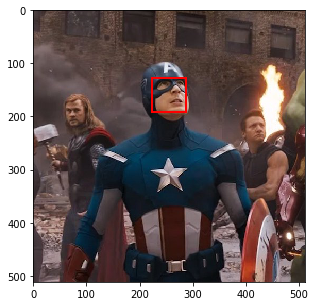

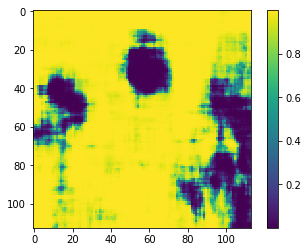

In [46]:
single_face_detection(Xtest, 'marvel', 512, 4, Do_facial=False)

 Now, we have our single face detection and corresponding heatmap

## Ⅲ -  Multi-face Detection
Since the method above only picks the minimum probability, thus it only draws one face, can't apply to image with more than one face. In order to improve our facial detection ability, we would introduce IoU technique in the following code.

### 1 -Filtering bounding box with a threshold on probability
We are going to apply a first filter by thresholding. We would like to get rid of any box for which the probability is less than a chosen threshold (in our case, we chose threashold=0.2).
 
 In our project, we define:
- a box using its two corners (upper left and lower right): (x1, y1, x2, y2)
- box_probability: the probability to be a face of  this box 

In [47]:
# Since we define a way to represent box location(using its upper left and lower right cornor) rather than
# upper left cornor which we got from coordinate list, we define a method to convert one from other.
def coord_convert_box(coord):
    box = []
    for c in coord:
        box.append((c[1], c[0], c[1]+64, c[0]+64))
    return box

In [48]:
# Filters boxes by threasholding on faces and its probability.
def filter_boxes(box_probability, boxes, threshold=0.2): 
    
    filtered_box_probability = []
    filtered_boxes = []
    
    for i, prob in enumerate(box_probability):
        if prob <= threshold:
            filtered_box_probability.append(prob)
            filtered_boxes.append(boxes[i])
    
    return filtered_box_probability, filtered_boxes

### 2-  Non-max suppression 
Even after filtering by thresholding over the probability, we still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression. 

### Note: 
Instruction and graph at this part are referenced from Coursera Deep Learning course

Non-max suppression uses the function called **"Intersection over Union"**, or IoU.
<img src="figure/iou.png" style="width:500px;height:400;">

- To calculate the area of a rectangle we need to multiply its height (y2 - y1) by its width (x2 - x1)
- We'll also define coordinates (xi1, yi1, xi2, yi2) of the intersection of two boxes. 
    - xi1 = maximum of the x1 coordinates of the two boxes
    - yi1 = maximum of the y1 coordinates of the two boxes
    - xi2 = minimum of the x2 coordinates of the two boxes
    - yi2 = minimum of the y2 coordinates of the two boxes

In [49]:
def IoU(box1, box2):
    xi1 = np.maximum(box1[0], box2[0])
    yi1 = np.maximum(box1[1], box2[1])
    xi2 = np.minimum(box1[2], box2[2])
    yi2 = np.minimum(box1[3], box2[3])
    inter_area = (yi2-yi1)*(xi2-xi1)
    
    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area/union_area
    return iou

Now we have IoU and then ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest probability(lowest box_probability in our case) if list is not empty.
2. Compute its overlap with all other boxes, and remove boxes that overlap it more than iou_threshold.
3. Go back to step 1 and iterate until there's no more boxes with a lower probability than the current selected box.

In [50]:
# This will remove all boxes that have a large overlap with the selected boxes.

def face_boxes(box_probability, boxes):
    facial_boxes = []
    facial_probability = []
    
    while box_probability:
        # Get the value and index of the minimum box probability.
        min_prob = min(box_probability)
        imin = box_probability.index(min_prob)
        curr_box = boxes[imin]
        
        # Append corresponding box and probability to facial_boxes 
        # waiting to be drawn in the future.
        facial_boxes.append(boxes[imin])
        facial_probability.append(min_prob)
        
        # Remove this probability and box at its index in related lists.
        box_probability.remove(min_prob)
        boxes.remove(boxes[imin])
        
        low_iou_boxes = []
        low_iou_probs = []
        for i, box in enumerate(boxes):
            iou = IoU(curr_box, box)
            if iou<0.1:
                low_iou_boxes.append(box)
                low_iou_probs.append(box_probability[i])
        
        # Update box_probability and boxes
        box_probability = low_iou_probs
        boxes = low_iou_boxes
    
    return facial_probability, facial_boxes

### 3 - Multi-face draw method
Implement a method displaying the output(512x512x3) of the deep CNN and filtering through all the boxes using the methods we've just implemented.

In [51]:
def multi_face_draw_box(probs, coord, img, threshold=0.2, Do_multi_face=False):
    
    if Do_multi_face==True:
    
        # Step1: convert coordinates into boxes, which has upper left and lower right corner
        boxes = coord_convert_box(coord)
    
        # Step2: eliminate any boxes which has low probability to be a face
        filtered_box_probability, filtered_boxes = filter_boxes(box_probability=probs, 
                                                                boxes=boxes, 
                                                                threshold=threshold)
    
        # Step3: get rid of overlapped boxes and output the clean face boxes
        facial_probability, facial_boxes = face_boxes(filtered_box_probability, 
                                                      filtered_boxes)
    
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(img[:,:,:])
    
        for face in facial_boxes:
            rect = mpatches.Rectangle((face[0], face[1]), 64, 64, fill=False, 
                                  edgecolor='red', linewidth=2)
            ax.add_patch(rect)
        plt.show()

In [52]:
with open("marvel_probs.p", "rb") as fp:
    two_probs = pickle.load(fp)
with open("marvel_coordinate.p", "rb") as fp1:
    two_coordinate = pickle.load(fp1)

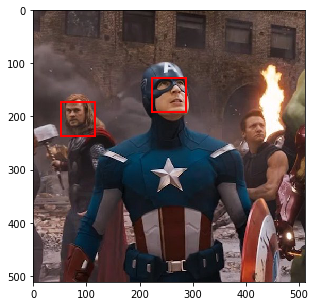

In [54]:
multi_face_draw_box(two_probs, two_coordinate, Xtest[0], 0.0001, True)

In [63]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

### Note
The following instructions and graphs are referenced from Corsera Deep Learning Course

## Ⅳ - YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 1 - Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents. 

<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u> **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u> **Flattening the last two last dimensions**<br> </center></caption>

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u> **Find the class detected by each box**<br> </center></caption>

Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, you'll use non-max suppression. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.


### 2 - Filtering with a threshold on class scores

You are going to apply a first filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It'll be convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes per cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the detection probabilities $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.



In [1]:
# GRADED FUNCTION: yolo_filter_boxes


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    # The following code are wrote by ourselves.
    # Step 1: Compute box scores
    
    box_scores = box_confidence*box_class_probs # get a (19,19,5,80) output
   
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
   
    box_classes = K.argmax(box_scores, axis=-1) # output shape (19,19,5)
    
    box_class_scores = K.max(box_scores, axis=-1) # output shape (19,19,5)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
   
    filtering_mask = box_class_scores >= threshold # output shape (19,19,5)
    
    # Step 4: Apply the mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes
    # The code above are wrote by ourselves.

### 3 - Non-max suppression ###

Even after filtering by thresholding over the classes scores, you still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

In [2]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    
    # The following code are wrote by ourselves.
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold = iou_threshold)
    
    
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    # The code above are wrote by ourselves.
    
    return scores, boxes, classes

### 4 -Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which we have provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```

In [3]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    # The following code are wrote by ourselves.
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=max_boxes, iou_threshold=iou_threshold)
    
    return scores, boxes, classes
    # The code above are wrote by ourselves.

### 5 - Test YOLO pretrained model on images
In this part, we are going to use a pretrained model and test it on the car detection dataset. As usual, we start by **creating a session to start your graph**. Run the following cell.

In [68]:
sess = K.get_session()

### 6 - Defining classes, anchors and image shape.
Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". Let's load these quantities into the model by running the next cell. 

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images.

In [69]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (1080., 1440.)   

In [70]:
import os 
os.path.abspath('.')

'C:\\Users\\hzj_joy\\Desktop\\Project_ML_withYOLO\\project_Scott'

In [71]:
yolo_model = load_model("C:\\Users\\hzj_joy\\Desktop\\Project_ML_withYOLO\\project_Scott\\model_data\\yolo.h5")

C:\Users\hzj_joy\Anaconda3\lib\site-packages\keras\models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains.

In [72]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

### 7 - Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. The following cell does that for you.

In [73]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

### 8 - Filtering boxes

`yolo_outputs` gave you all the predicted boxes of `yolo_model` in the correct format. You're now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this. 

In [74]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### 9 - Run the graph on an image

Let the fun begin. You have created a (`sess`) graph that can be summarized as follows:

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>



The code below also uses the following function:
```python
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
which outputs:
- image: a python (PIL) representation of your image used for drawing boxes. You won't need to use it.
- image_data: a numpy-array representing the image. This will be the input to the CNN.



In [4]:
def predict(sess, image_file):
    
    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    # The following code are wrote by ourselves.
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],{yolo_model.input: image_data,K.learning_phase():0})
    # The code above are wrote by ourselves.
    
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 4 boxes for migo.jpg
chair 0.64 (946, 640) (1223, 1018)
chair 0.68 (1346, 603) (1440, 947)
person 0.78 (723, 430) (1201, 999)
tvmonitor 0.82 (370, 161) (780, 466)


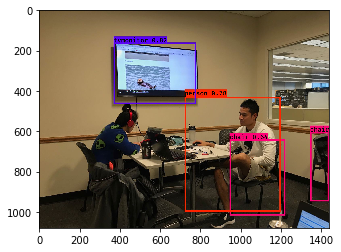

In [76]:
out_scores, out_boxes, out_classes = predict(sess, "migo.jpg")

## References: 
The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/)